In [5]:
import networkx as nx
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
%pylab inline
from enum import Enum

Populating the interactive namespace from numpy and matplotlib


### Reading data
Removing rows with errors and considering problem in encoding (commas inside title)

In [6]:
YEAR = 0
CODE = 1
GENRE = 2
AUTHORS = 3
TITLE = 4

def strip(string):
    return re.sub(r'([^\s\w]|_)+', '', string.lower()).strip()

books = []
with open('data.csv', 'r') as f:
    for line in f:
        elements = line.split(',')
        if len(elements) < 5:
            continue
        # Year, code and genre
        book = [col.strip() for col in elements[:3]]
        # Authors
        book.append([strip(author) for author in elements[3].split('&')])
        # Title
        book.append(','.join(elements[4:]).strip())
        books.append(book)

## Creating Graph

### Authors

In [7]:
authorGraph = nx.Graph()
for book in books:
    authorGraph.add_nodes_from(book[AUTHORS])

### Colaborations

In [8]:
for book in books:
    for i, author in enumerate(book[AUTHORS]):
        for other_author in book[AUTHORS][i+1:]:
            authorGraph.add_edge(author, other_author)

#### Number of authors:

In [9]:
len(authorGraph.nodes())

3952

#### Number of collaborations

In [10]:
len(authorGraph.edges())

7891

#### Plot:

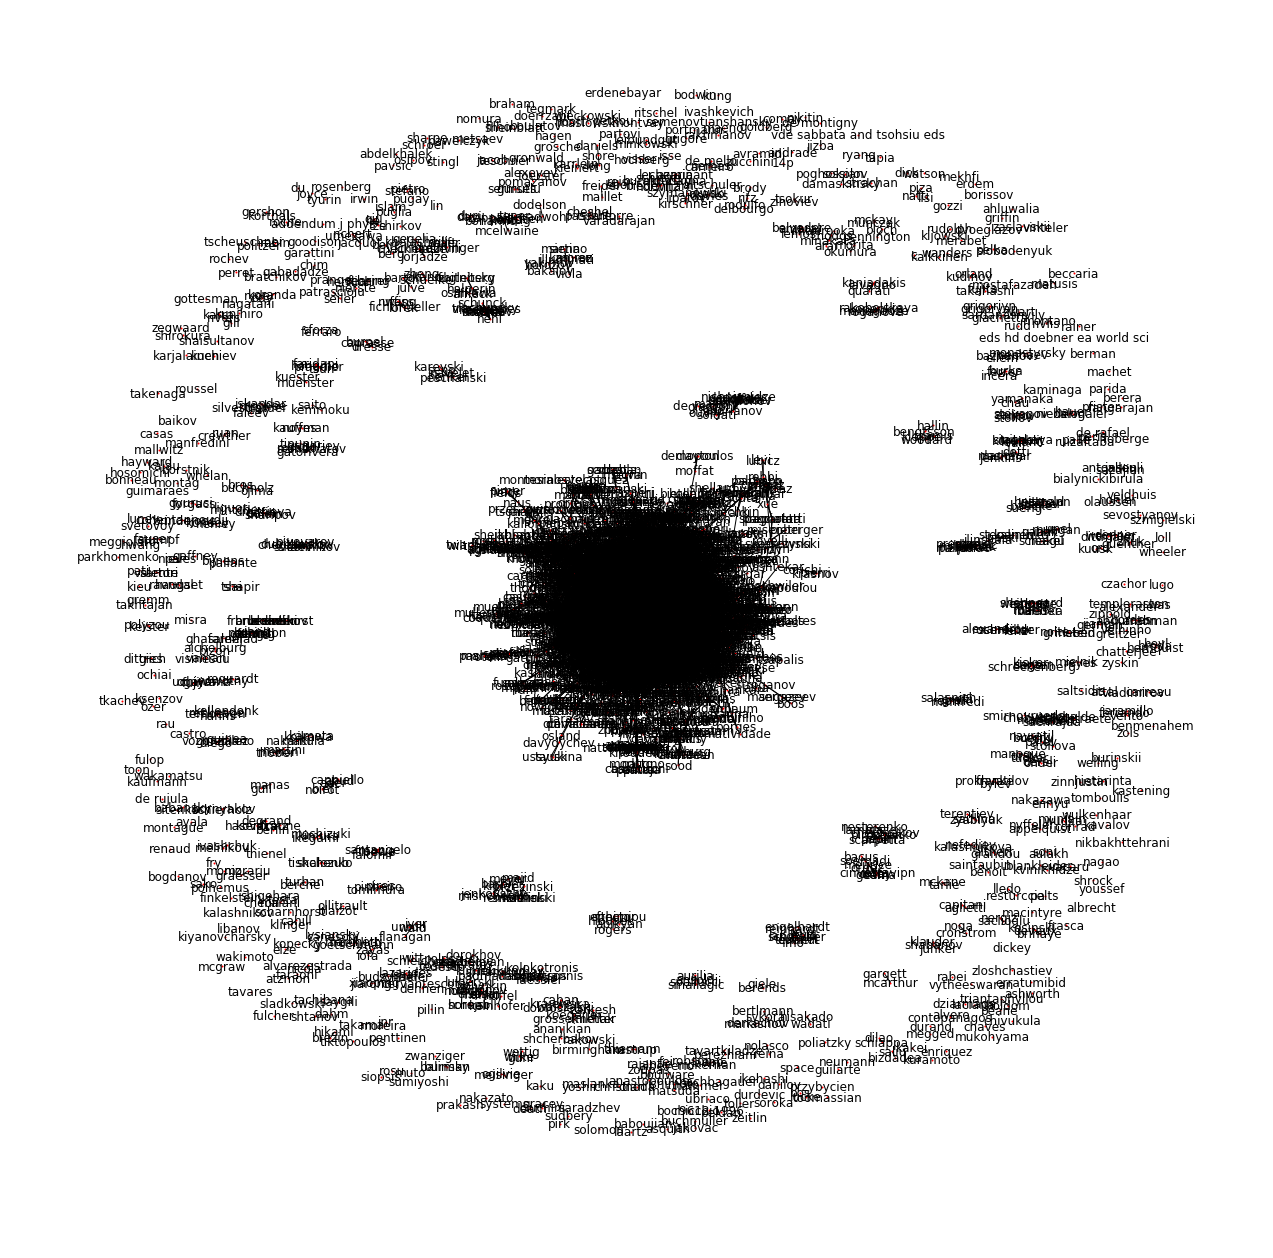

In [11]:
figsize(17, 17)
nx.draw(authorGraph,with_labels=True, node_size=1)

## Distributions

### Linear

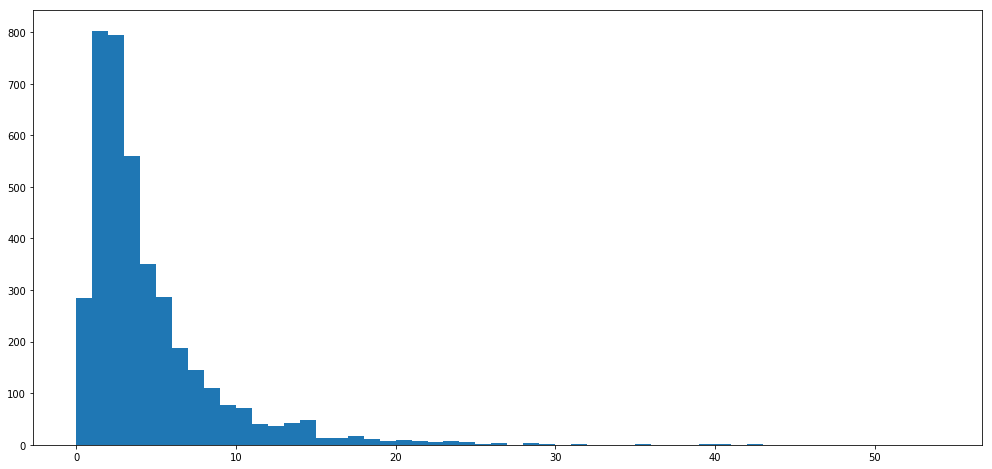

In [12]:
figsize(17, 8)
lineal_plot = pyplot.hist([authorGraph.degree(node) for node in authorGraph], bins=range(55))

### Semilog

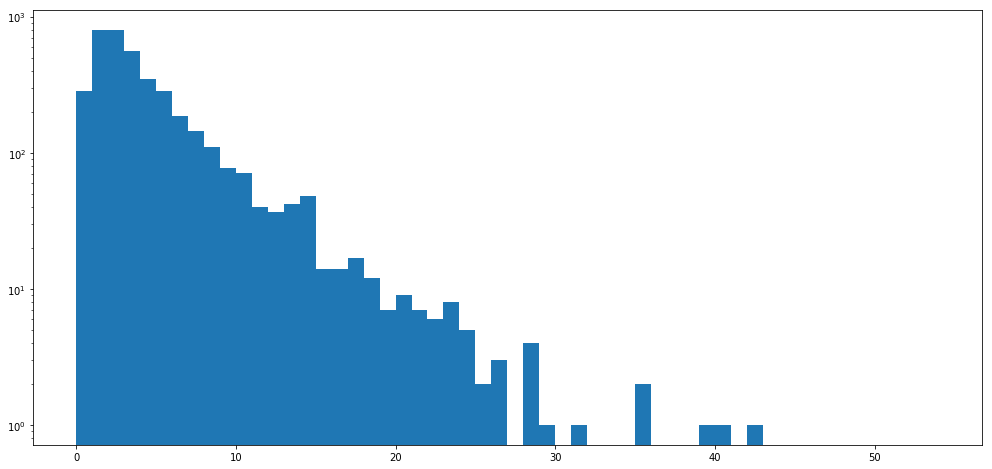

In [13]:
figsize(17, 8)
semilog_plot = pyplot.hist([authorGraph.degree(node) for node in authorGraph], log=True, bins=range(55))

### Log-Log

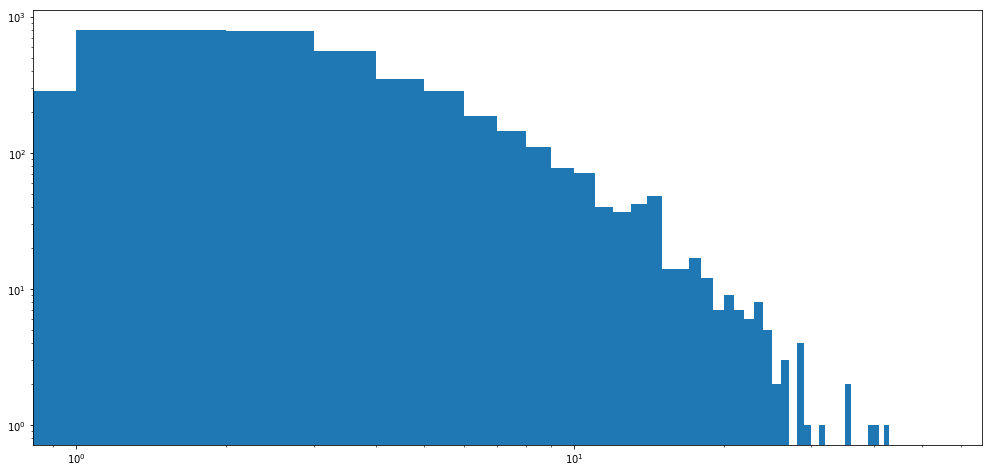

In [14]:
figsize(17, 8)
fig = pyplot.figure()
ax = fig.add_subplot(1,1,1)
loglog_plot = ax.hist([authorGraph.degree(node) for node in authorGraph], log=True, bins=range(55))
ax.set_xscale('log')

Se puede ver a simple vista que es una distribucion LogNormal. En el primer plot se ve la forma clasica de esta distribucion, y en la segunda se ve que se transforma en lineal al tener una escala logaritmica en 'y'

## Connected components

In [15]:
connected_components = [component for component in nx.connected_component_subgraphs(authorGraph)]

### Number of connected components

In [16]:
len(connected_components)

506

### Size of biggest component

In [17]:
connected_components.sort(key= lambda component: component.number_of_nodes(), reverse=True)
biggestComponent = connected_components[0]
secondBiggestComponent = connected_components[1]
print('Size biggest component: {}'.format(len(biggestComponent)))
print('Size second biggest component: {}'.format(len(secondBiggestComponent)))

Size biggest component: 3035
Size second biggest component: 12


## Neighborhoods sizes

In [18]:
from random import choice

def getNeighborhoodGrowth(node, graph):
    seenNodes = set([node])
    nSeenNodes = []
    nDiscoveredNodes = []
    newNodes = set([node])
    while len(seenNodes) < graph.number_of_nodes():
        currentNewNodes = set()
        for newNode in newNodes:
            for neighbor in graph[newNode]:
                currentNewNodes.add(neighbor)
        newNodes = currentNewNodes.difference(seenNodes)
        seenNodes.update(newNodes)
        nSeenNodes.append(len(seenNodes))
        nDiscoveredNodes.append(len(newNodes))
    return {'seenNodes': np.array(nSeenNodes), 'discoveredNodes': np.array(nDiscoveredNodes)}

### Random sample

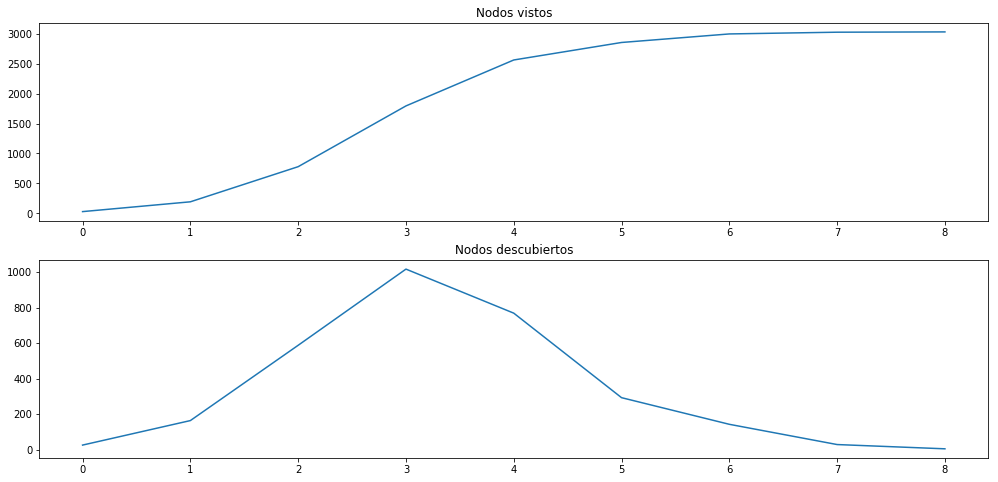

In [37]:
figsize(17, 8)
startNode = choice(list(biggestComponent.nodes()))
stats = getNeighborhoodGrowth(startNode, biggestComponent)

fig = pyplot.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(stats['seenNodes'])
ax.set_title('Nodos vistos')
ax = fig.add_subplot(2,1,2)
ax.plot(stats['discoveredNodes'])
ax.set_title('Nodos descubiertos')

### Mean from several runs

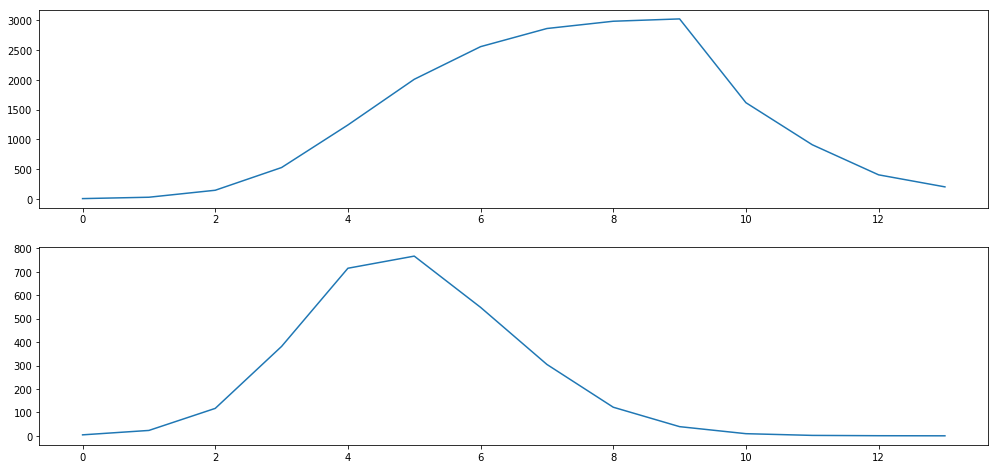

In [20]:
figsize(17, 8)

def addArrays(a, b):
    if len(a) < len(b):
        b[:len(a)] += a
        return b
    else:
        a[:len(b)] += b
        return a 

times = 30
sumSeen = np.array([0])
sumDiscovered = np.array([0])
nodes = list(biggestComponent.nodes())

for _ in range(times):
    startNode = choice(nodes)
    nodes.remove(startNode)
    stats = getNeighborhoodGrowth(startNode, biggestComponent)
    sumSeen = addArrays(sumSeen, stats['seenNodes'])
    sumDiscovered = addArrays(sumDiscovered, stats['discoveredNodes'])

fig = pyplot.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(sumSeen/times)
ax = fig.add_subplot(2,1,2)
ax.plot(sumDiscovered/times)

Yo diria que es robusto porque el promedio es casi el mismo que el caso aislado. En el primer grafico que muestra la cantidad de vistos totales en cada paso, cae al final, porque hay ciertos nodos que ven a todos los nodos antes que otros, entonces el promedio hace que pase eso.
La relacion con el fenomeno es directa, ya que es un grafo de relaciones entre individuos. Y tiene mucho sentido, dados los datos, que se afirme que la mayoria de pares de personas esten conectados por no mas de 6 relaciones intermedias, ya que podemos ver que el centro aqui de mayor descubrimiento de personas es 5. Aunque si vemos el total, vemos que el centro es 8, pero la diferencia entre los conocidos entre la iteración 8 y 6 es bastante menor comparada con los conocidos hasta el 6, de hecho se ve que la derivada es maxima en la iteracion 4.

Hay que tener en cuenta igual que al ser un grupo muy especifico de personas, del ambito academico o literario, puede no llegar a ser un grupo representativo del resto del mundo.

## Clustering

### Clustering coefficient for biggest component

In [21]:
nx.average_clustering(biggestComponent)

0.4827298241606101

### Average shortest path length for biggest component

In [22]:
nx.average_shortest_path_length(biggestComponent)

6.067814195840876

### Generating random graph with same degree distribution

In [23]:
randomGraph = nx.expected_degree_graph([authorGraph.degree(node) for node in authorGraph])
randomGraphConnectedComponents = [component for component in nx.connected_component_subgraphs(randomGraph)]
randomGraph = max(randomGraphConnectedComponents, key= lambda component: component.number_of_nodes())
print('Clustering coefficient: {}'.format(nx.average_clustering(randomGraph)))
print('Average shortest path: {}'.format(nx.average_shortest_path_length(randomGraph)))

Clustering coefficient: 0.8806129665619759
Average shortest path: 1.2121212121212122


## Stars
Primero claramente me fijaria en el grado de los autores, los que tienen mayor grado se relacionan con la mayor cantidad de otros autores, por lo que estos ultimos supongo que lo valoran a ese autor como para trabajar con el, y si muchos quieren trabajar con el, algo bueno debe tener.
Lo segundo seria los que tardan menos en alcanzar a todos los demas autores, ya que serian los que unen mas los subconjuntos.

In [24]:
authorsDegrees = [{'author': author, 'degree': biggestComponent.degree(author)} for author in biggestComponent]
authorsDegrees.sort(key= lambda a: (a['degree'], a['author']), reverse=True)

In [25]:
authorsStepsToAll = [{'author': author, 'steps': len(getNeighborhoodGrowth(author, biggestComponent)['seenNodes'])} for author in biggestComponent]
authorsStepsToAll.sort(key= lambda a: (a['steps'], a['author']))

In [35]:
for i, author in enumerate(authorsStepsToAll[:10]):
    print('Estrella nº{}: {} llega a todos los demas autores en {} pasos'.format(i ,author['author'].title(), author['steps']))

Estrella nº0: Vafa llega a todos los demas autores en 8 pasos
Estrella nº1: Adler llega a todos los demas autores en 9 pasos
Estrella nº2: Alford llega a todos los demas autores en 9 pasos
Estrella nº3: Amelinocamelia llega a todos los demas autores en 9 pasos
Estrella nº4: Anderson llega a todos los demas autores en 9 pasos
Estrella nº5: Anselmi llega a todos los demas autores en 9 pasos
Estrella nº6: Argyres llega a todos los demas autores en 9 pasos
Estrella nº7: Balasubramanian llega a todos los demas autores en 9 pasos
Estrella nº8: Berkovits llega a todos los demas autores en 9 pasos
Estrella nº9: Bershadsky llega a todos los demas autores en 9 pasos


In [34]:
for i, author in enumerate(authorsDegrees[:10]):
    print('Estrella nº{}: {} se conecta directamente con {} autores'.format(i ,author['author'].title(), author['degree']))

Estrella nº0: Lee se conecta directamente con 55 autores
Estrella nº1: Ambjorn se conecta directamente con 42 autores
Estrella nº2: Park se conecta directamente con 40 autores
Estrella nº3: Kim se conecta directamente con 39 autores
Estrella nº4: Vafa se conecta directamente con 35 autores
Estrella nº5: Ferrara se conecta directamente con 35 autores
Estrella nº6: Strominger se conecta directamente con 31 autores
Estrella nº7: Lu se conecta directamente con 29 autores
Estrella nº8: Pope se conecta directamente con 28 autores
Estrella nº9: Odintsov se conecta directamente con 28 autores


Se ve cierta similaridad, pero por el fenomeno de los grados de separacion, la metrica de pasos muestra muchos autores con la misma cantidad de pasos. Entonces yo tomaria primero la metrica de grados. La similaridad se ve en que los primeros autores en la metrica de grados se encuentran en los buckets primeros de la metrica de pasos.

### Destroying biggest component
Voy a suponer que decir que desaparezca la componente mas grande significa quitar nodos hasta que cualquier componente sea menor en tamaño a la segunda componente mas grande del grafo original.

In [36]:
biggestComponentCopy = biggestComponent.copy()
authorToRemove = (author['author'] for author in authorsDegrees)
steps = 0
while max([component.number_of_nodes() for component in nx.connected_component_subgraphs(biggestComponentCopy)]) >= secondBiggestComponent.number_of_nodes():
    biggestComponentCopy.remove_node(next(authorToRemove))
    steps += 1
print('La componente gigante desaparece borrando los primeros {} autores ordenados segun su grado'.format(steps))

La componente gigante desaparece borrando los primeros 1126 autores ordenados segun su grado
